In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from itertools import chain


C:\Users\Anna Vallvé Nicolás\AppData\Local\Temp\ipykernel_6096\885636450.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


# 1. Loading and visualization Data

In [15]:
train = pd.read_csv('written_name_train_v2.csv')
test = pd.read_csv('written_name_validation_v2.csv')
train_img_dir = 'train_v2/train'
test_img_dir = 'validation_v2/validation'
train.head(6), test.head(6)

(          FILENAME   IDENTITY
 0  TRAIN_00001.jpg  BALTHAZAR
 1  TRAIN_00002.jpg      SIMON
 2  TRAIN_00003.jpg      BENES
 3  TRAIN_00004.jpg    LA LOVE
 4  TRAIN_00005.jpg     DAPHNE
 5  TRAIN_00006.jpg      LUCIE,
               FILENAME    IDENTITY
 0  VALIDATION_0001.jpg       BILEL
 1  VALIDATION_0002.jpg  LAUMIONIER
 2  VALIDATION_0003.jpg         LEA
 3  VALIDATION_0004.jpg   JEAN-ROCH
 4  VALIDATION_0005.jpg        RUPP
 5  VALIDATION_0006.jpg  UNREADABLE)

# 2. Data Cleaning

##### Remove all rows that have as IDENTITY = UNREADABLE

In [16]:
print("Tain set: ",train['IDENTITY'].shape[0])
print("UNREADABLE in train set : ", train['IDENTITY'].isnull().sum())
print("Test set: ", test['IDENTITY'].shape[0])
print("UNREADABLE in validation set : ", test['IDENTITY'].isnull().sum())


Tain set:  330961
UNREADABLE in train set :  565
Test set:  41370
UNREADABLE in validation set :  78


In [17]:
train = train[train['IDENTITY'] != 'UNREADABLE']
train = train.dropna()
test = test[test['IDENTITY'] != 'UNREADABLE']
test = test.dropna()
print("train:",train.shape[0]," test:",test.shape[0])


train: 330294  test: 41280


# 3. Transformation data

#### For model to perform better , it must:
* Resize all data to one size (in my case i choose [284,62])
* Convert image from (R,G,B) to binary (1 or 0) 

In [18]:
def to_binary(image):
    image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB),dsize=(284,62)) #convertir la imatge de BGR a RGB i redimensionarla
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convertir la imatge a escala de grisos
    (thresh, image_binary) = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) #aplicar un umbral per separar els pixels de primer pla i de fons de manera òptima
    image_binary = cv2.threshold(image_gray, thresh, 255, cv2.THRESH_BINARY)[1] #aplicar novament un unmbral per asegurar una imatge binaria clara
    image_binary = image_binary / 255 #dividir els valors del pixels entre 255 per obtenir valors de 0 o 1
    return image_binary


## Loading data
* train_data_img   containing all the pictures of train data
* test_data_img   containing all the pictures of test data
* train_data_idt   containing all IDENTITY of train data
* test_data_idt   containing all IDENTITY of test data

In [19]:
train_data_img = [] #emmagatzemar imatges entrenament
train_data_idt = [] #emmagatzemar identitat de les imatges entrenament
#for i in range(test.shape[0]):   #it's take too longe to do all images
for i in range(1000): #iterar els primers 1000 exemples del conjunt d'entrenament
    image_filename = train['FILENAME'].iloc[i] #exreure el nom de l'arxiu de la imatge 
    image_path = os.path.join(train_img_dir,image_filename) #concatenar el directori de les imatges d'entrenament amb el nom d'arxiu per obtenir la ruta completa de la imatge
    image = cv2.imread(image_path) #llegir la imatge
    image = to_binary(image) #aplicar funció anterior per convertir la imatge a binari
    train_data_img.append(image) #afegir la imatge binaria a la llista 
    train_data_idt.append(train['IDENTITY'].iloc[i]) #afegir la identitat de la imatge 
    

In [20]:
test_data_img = []
test_data_idt = []
#for i in range(test.shape[0]):
for i in range(1000):
    image_filename = test['FILENAME'].iloc[i]
    image_path = os.path.join(test_img_dir,image_filename)
    image = cv2.imread(image_path)
    image = to_binary(image)
    test_data_img.append(image)
    test_data_idt.append(test['IDENTITY'].iloc[i])  
    

In [21]:
test_data_img = []
test_data_idt = []
#for i in range(test.shape[0]):
for i in range(1000):
    image_filename = test['FILENAME'].iloc[i]
    image_path = os.path.join(test_img_dir,image_filename)
    image = cv2.imread(image_path)
    image = to_binary(image)
    test_data_img.append(image)
    test_data_idt.append(test['IDENTITY'].iloc[i])  
    

BALTHAZAR
(62, 284)


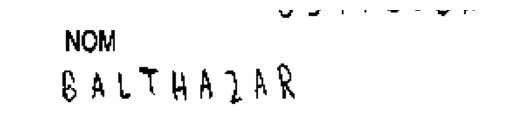

SIMON
(62, 284)


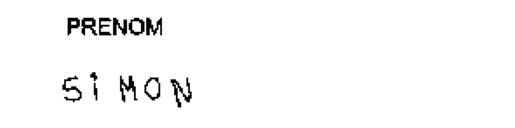

BENES
(62, 284)


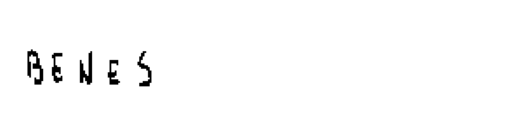

BILEL
(62, 284)


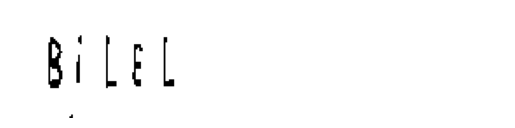

LAUMIONIER
(62, 284)


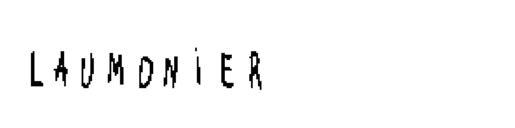

LEA
(62, 284)


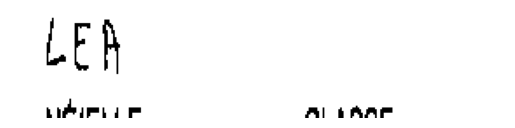

In [22]:
for i in range(3):
    print(train_data_idt[i]) #imprimir una identitat associada a una imatge
    print(train_data_img[i].shape) #imprimir la forma de la imatge
    plt.imshow(train_data_img[i],cmap='gray') #mostrar la imatge en escala de grisos (binari)
    plt.axis('off')
    plt.show()
for i in range(3):
    print(test_data_idt[i])
    print(test_data_img[i].shape)
    plt.imshow(test_data_img[i],cmap='gray')
    plt.axis('off')
    plt.show()
    

## coding IDENTITY 


#### 1. extract all the letters used in all data (IDENTITY)

In [23]:
all_data = train_data_idt + test_data_idt #concatenar les llistes train i test creades anteriorment en una sol
# Concatenate names into a single string
all_characters = ''.join(all_data)

# Create a set to get unique characters
unique_characters_set = set(all_characters) #eliminar duplicats

# Convert the set back to a list if needed
unique_characters_list = list(unique_characters_set)

print(unique_characters_list)
print(len(unique_characters_list))


['B', 'C', 'F', 'Q', 'H', 'G', 'E', 'P', 'S', 'T', 'W', 'I', 'R', 'J', "'", 'L', 'Z', 'D', 'U', 'N', 'V', ' ', 'M', 'X', 'O', '-', 'A', 'K', 'Y']
29


#### 2. Creat dictionary 

* Encode each character into vector as {‘a’:[1,0,0,0], ‘b’:[0,1,0,0] …….. ‘z’:[0,0,0,1]} etc. 

In [24]:
lb = LabelBinarizer() #crear una instancia de la classe 'LabelBinarizer'
lb.fit(unique_characters_list) #ajustar la instancia als caràcters únics presents en les entitats i construir una codificació binaria per cada un
lb.classes_ #proporcionar una llista oredenada dles caràcters únics
dec = {} #diccionari que s'utilitza per mapejar cada caràcter únic a la seva corresponent codificació binaria
for i in range(len(unique_characters_list)): #iteració sobre la llista de caràcters únics 
    if unique_characters_list[i] in dec.keys(): #verificació si ja existeixen al diccionari
        pass
    else: #si no existeixen 
        a = lb.transform([unique_characters_list[i]]) #obtindre la codificació binaria del caràcter actual
        a = list(chain(*a)) #flattened_list from [[....]] to []
        dec[unique_characters_list[i]]= a #assignar la codificació binaria al diccionari, abm el caràcter coma clau i la codificació com a valor
        

In [25]:
print("train data longest word :")
length_of_longest_word_in_train = len(max(train_data_idt, key=len)) #trobar la llargada de la paraula més llarga en termes de longitud de caràcters en el conjunt d'entrenament
print(length_of_longest_word_in_train)
word_with_longest_characters = max(train_data_idt, key=len) #trobar la paraula més llarga en termes de longitud de caràcters en el conjunt d'entrenament
print(word_with_longest_characters)
print()
print("test data longest word :")
length_of_longest_word_in_test = len(max(test_data_idt, key=len)) #trobar la llargada de la paraula més llarga en termes de longitud de caràcters en el conjunt de prova
print(length_of_longest_word_in_test)
word_with_longest_characters = max(test_data_idt, key=len) #trobar la paraula més llarga en termes de longitud de caràcters en el conjunt de prova
print(word_with_longest_characters)


train data longest word :
19
DI - BIN - LOMBARDI

test data longest word :
16
BELMERROUBICARRO


#### 3. coding all IDENTITY using our dictionary  


In [27]:

# Function to convert a name to a list of vectors using the dictionary
def name_to_vectors(name,max_len,num_char):
    zeros_list = [0] * num_char #crear llista longitud catàcters únics 
    num_vec_to_add = max_len - len(name) #calcular el nombre de vectors que falta afegir per arribar a la longitud màxima
    list_vc_name = [dec[char] for char in name] #iteracio sobre cada caràcter per obtenir la corresponent codificació binaria
    
    for i in range(num_vec_to_add):
        list_vc_name.append(zeros_list) #afegir tants vectors de zeros com vectors falten
    return list_vc_name

# Creating a list of vectors for each name
vectors_list_train_idt = [name_to_vectors(name, length_of_longest_word_in_train, len(unique_characters_list)) for name in train_data_idt] # for train data
vectors_list_test_idt = [name_to_vectors(name, length_of_longest_word_in_train, len(unique_characters_list)) for name in test_data_idt] # for test data 

#for name, vectors in zip(names, vectors_list):
    #print(f"{name}: {vectors}")
vectors_list_train_idt = np.array(vectors_list_train_idt) #change from list to numpy array
vectors_list_test_idt = np.array(vectors_list_test_idt)
print(vectors_list_train_idt.shape)
print(vectors_list_test_idt.shape)


(1000, 19, 29)
(1000, 19, 29)


In [28]:
#LB = LabelBinarizer()
#train_data_idt = LB.fit_transform(train_data_idt)
#test_data_idt = LB.fit_transform(test_data_idt)
#print(test_data_idt[0:5])

train_data_img = np.array(train_data_img) #convertir de llista a matriu de imatges
train_data_img = train_data_img.reshape(-1,62,284,1) #canviar la forma de la matriu de imatges 

test_data_img = np.array(test_data_img)
test_data_img = test_data_img.reshape(-1,62,284,1)

#train_data_idt = np.array(train_data_idt)
#test_data_idt = np.array(test_data_idt)

#print(type(train_data_idt[1]), type(test_data_idt))
print(train_data_img.shape,vectors_list_train_idt.shape)
print(test_data_img.shape,vectors_list_test_idt.shape)


(1000, 62, 284, 1) (1000, 19, 29)
(1000, 62, 284, 1) (1000, 19, 29)


# 4. Creat model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [30]:
model = Sequential() #crear una instància del model Sequencial (per crear una pila lineal de capas de xarxes neuronals)

model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(62,284,1))) #afegir una capa Conv2D al model. S'utilitza per aplicar filtres a les imatges d'entrada per extreure característiques importants
model.add(MaxPooling2D()) #afegir capa de MaxPooling2D al model. S'utilitza per reduir la mida espacial de la sortida de la capa convolucional anterior

model.add(Conv2D(32, (3,3), 1, activation='relu')) 
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten()) #afegir una capa Flatten al model. S'utilitza per convertir els mapas de caracterítiques de les capes convolucionals a un vector unidimensional per que puguin ser alimentats a les capes densament conectades
model.add(Dense(256, activation='relu')) #afegir una capa Dense al model amb 256 unitats i activació ReLU. Es una capa completament conectada que te conexions entre cada unitat en la capa anterior i cada unitat d'aquesta capa
model.add(Dense(len(unique_characters_list), activation='softmax')) #afegir una capa Dense de sortida amb un numero d'unitats igual al nombre de caracters únics a les dades i la funció d'activacio softmax. S'utilitza per generar la distribució de probabilitat sobre les classes possibles a la sortida del model


c:\Users\Anna Vallvé Nicolás\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#compilar el model de xarxa neuronal definit anteriorment 
#optimizer='adam': algorisme per entrenar xarxes neuronals. Ajusta els pesos de la xarxa durant l'entrenament per minimitzar funció de pèrdua
#loss='categorical_crossentropy': funció de pèrdua utilitzada per problemes de classificació amb múltiples classes. Cada exemple pot pertanyer nomes auna classe 
#metrics=['accuracy']: la mètrica precisió s'utilitza per evaluar el rendiment del model en el conjunt d'entrenament

In [32]:
model.summary()
#imprimir un resum de l'arquitectura i els paràmetres del model de xarxes neuronal

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 282, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 141, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 139, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 69, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 67, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 33, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3168)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       811,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 828,141 (3.16 MB)

 Trainable params: 828,141 (3.16 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
print("train_data_img shape:", train_data_img.shape)
print("vectors_list_train_idt shape:", vectors_list_train_idt.shape)


train_data_img shape: (1000, 62, 284, 1)
vectors_list_train_idt shape: (1000, 19, 29)


In [34]:
#vectors_list_train_idt = vectors_list_train_idt.reshape(-1, len(unique_characters_list))
#vectors_list_test_idt = vectors_list_test_idt.reshape(-1, len(unique_characters_list))

#history = model.fit(train_data_img, vectors_list_train_idt, epochs=20, batch_size=8, validation_data=(test_data_img, vectors_list_test_idt), verbose=1)
